# Laboratory Exercise: Poker Hand Classification from 5 Cards

## Introduction

In this laboratory exercise, you will build a **multi-class classification model** that predicts the **poker hand category** given **five playing cards**. Each data sample represents a complete 5-card poker hand, and the task is to correctly classify it into one of the standard poker hand types (e.g. *Nothing in hand*, *One pair*, *Straight*, *Flush*, *Royal flush*, etc.).

You will implement a **full machine learning pipeline using PyTorch**, including data preprocessing, dataset definition, model building, training, evaluation, visualization, and final testing.

This exercise focuses on **structured categorical data**, **multi-class classification**, and correct usage of **CrossEntropyLoss**.

## Problem Definition

- **Task:** Multiclass classification
- **Target column:** `Hand`
- **Goal:** Predict what will the winning hand be

You will work with a provided dataset (`dataset.csv`) and implement a complete **machine learning training pipeline** using PyTorch.

## Tasks Overview

You are required to implement the following components:

1. **Data Preparation**
   - Load the `dataset.csv` file
   - Separate features from the target column `Hand`
   - Split the data into training, validation, and test sets
   - Apply any required preprocessing

2. **Dataset Class**
   - Implement an `PockerDataset` class compatible with PyTorch’s `DataLoader`

3. **Model Building**
   - Implement a `build_model` function that returns a neural network for multiclass classification

4. **Training and Evaluation**
   - Implement:
     - `train_one_epoch`
     - `evaluate`
     - `test`
   - Train the model for a fixed number of epochs
   - Track training loss, validation loss, and validation accuracy for each epoch

5. **Visualization**
   - Plot:
     - Training loss vs. epochs
     - Validation loss vs. epochs
     - Validation accuracy vs. epochs

6. **Testing and Reporting**
   - Evaluate the final model on the test dataset
   - Generate a **classification report** (precision, recall, F1-score)


## Model Comparison Requirement

You must design and train **two different model configurations**, for example:
- Different network depths or widths
- Different activation functions
- Different regularization strategies (e.g. dropout)

For **each model**, you must:
- Train it for the same number of epochs
- Plot training and validation metrics
- Evaluate it on the test set

## Dataset Description

You are given a CSV dataset with the following structure:

```text
Card 1,Card 2,Card 3,Card 4,Card 5,Hand
Jack Spades,King Spades,10 Spades,Queen Spades,Ace Spades,Royal flush
Queen Diamonds,Jack Diamonds,King Diamonds,10 Diamonds,Ace Diamonds,Royal flush
2 Heart,4 Heart,5 Heart,3 Heart,6 Heart,Straight flush
Ace Heart,Ace Spades,9 Diamonds,5 Heart,3 Spades,One pair
```

In [1]:
from typing import Tuple

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import (
    MinMaxScaler,
    LabelEncoder,
    OrdinalEncoder,
)

In [3]:
df = pd.read_csv("C:/Users/bojan/Downloads/dataset.csv")

In [4]:
df.head()

,Card 1,Card 2,Card 3,Card 4,Card 5,Hand
0,Jack Spades,King Spades,10 Spades,Queen Spades,Ace Spades,Royal flush
1,Queen Diamonds,Jack Diamonds,King Diamonds,10 Diamonds,Ace Diamonds,Royal flush
2,10 Clubs,Jack Clubs,Ace Clubs,King Clubs,Queen Clubs,Royal flush
3,Ace Clubs,King Clubs,Queen Clubs,Jack Clubs,10 Clubs,Royal flush
4,2 Heart,4 Heart,5 Heart,3 Heart,6 Heart,Straight flush


In [5]:
df.isnull().sum()

Card 1    0
Card 2    0
Card 3    0
Card 4    0
Card 5    0
Hand      0
dtype: int64

In [6]:
def prepare_data(df: pd.DataFrame) -> Tuple[
    pd.DataFrame, pd.DataFrame, pd.DataFrame,
    pd.DataFrame, pd.DataFrame, pd.DataFrame,
    ColumnTransformer
]:
    """
    Prepare the poker hands dataset for training and evaluation.

    The input DataFrame contains five cards describing a complete poker hand
    and a categorical target column "Hand" indicating the poker hand type
    (e.g. One pair, Straight, Flush, Royal flush).

    Steps (you MUST follow these steps):
    1. Split each card column ("Card 1" to "Card 5") into:
       - Rank (2–10, Jack, Queen, King, Ace)
       - Suit (Clubs, Diamonds, Hearts, Spades)
    2. Encode card features:
       - Ordinal-encode ranks using poker order
       - Label encode suits
    3. Separate features (X) and target (y), where the target column is "Hand".
    4. Label-encode the target labels into integer class indices.
    5. Use a ColumnTransformer to apply the encoders to all card features.
    6. Fit the preprocessor.
    7. Split the data in TWO stages (keep stratification):
       - First split into train and test:
            * test_size = 0.2
            * random_state = 42
            * stratify = y
       - Then split the training part into train and validation:
            * test_size = 0.2   (20% of the training set)
            * random_state = 42
            * stratify = y_train
    8. Return:
         X_train, X_val, X_test, y_train, y_val, y_test, preprocessor

    Notes:
    - The returned X arrays must be fully numeric.
    - The returned y arrays must contain integer class labels.
    - The data must be suitable for PyTorch multi-class classification.
    """

    #1
    card_cols = [f"Card {i}" for i in range(1,6)]
    for col in card_cols:
        df[f"{col}_Rank"] = df[col].apply(lambda x: x.split()[0])
        df[f"{col}_Suit"] = df[col].apply(lambda x: x.split()[1])

    df = df.drop(columns=card_cols)

    #2

    rank_order = [
        "2", "3", "4", "5", "6", "7", "8", "9", "10",
        "Jack", "Queen", "King", "Ace"
    ]

    rank_cols = [f"Card {i}_Rank" for i in range(1, 6)]
    suit_cols = [f"Card {i}_Suit" for i in range(1, 6)]

    rank_encoder = OrdinalEncoder(categories=[rank_order] * 5)
    suit_encoder = OrdinalEncoder()

    #3
    X = df.drop(columns=["Hand"])
    y = df["Hand"]

    #4
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    #5
    preprocessor = ColumnTransformer(
        transformers=[
            ("rank", rank_encoder, rank_cols),
            ("suit", suit_encoder, suit_cols),
        ]
    )

    #6
    X_processed = preprocessor.fit_transform(X)
    X_processed = pd.DataFrame(X_processed)

    #7
    X_train, X_test, y_train, y_test = train_test_split(
        X_processed,
        y_encoded,
        test_size=0.2,
        random_state=42,
        stratify=y_encoded
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train,
        y_train,
        test_size=0.2,
        random_state=42,
        stratify=y_train
    )


    #8
    return (
        X_train, X_val, X_test,
        y_train, y_val, y_test,
        preprocessor
    )
    
    #raise NotImplementedError()

In [7]:
class PockerDataset(Dataset):
    """
    A PyTorch Dataset for poker hand classification.

    Each sample consists of:
    - a numeric feature vector representing five playing cards
    - a multiclass label indicating the poker hand category

    Requirements:
    - __init__(self, X, y):
        * X: numpy array of numeric features
        * y: array-like of integer class labels
        * Store:
            - X as a float32 tensor
            - y as a long tensor (class indices)
    - __len__(self):
        * Return the number of samples
    - __getitem__(self, idx):
        * Return (X[idx], y[idx])
    """
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    pass

In [8]:
df.head()

,Card 1,Card 2,Card 3,Card 4,Card 5,Hand
0,Jack Spades,King Spades,10 Spades,Queen Spades,Ace Spades,Royal flush
1,Queen Diamonds,Jack Diamonds,King Diamonds,10 Diamonds,Ace Diamonds,Royal flush
2,10 Clubs,Jack Clubs,Ace Clubs,King Clubs,Queen Clubs,Royal flush
3,Ace Clubs,King Clubs,Queen Clubs,Jack Clubs,10 Clubs,Royal flush
4,2 Heart,4 Heart,5 Heart,3 Heart,6 Heart,Straight flush


In [9]:
def train_one_epoch(model: nn.Module,
                    train_loader: DataLoader,
                    criterion,
                    optimizer) -> float:
    """
    Train the model for ONE epoch on the training dataset.

    This is a multi-class classification task for poker hand prediction.

    Requirements:
    - Set the model to training mode using model.train()
    - Iterate over batches from train_loader
    - For each batch:
        * Compute model outputs (logits)
        * Compute the loss using CrossEntropyLoss
        * Zero the gradients
        * Perform backpropagation
        * Update model parameters using the optimizer
    - Accumulate the training loss over all batches
    - Return the average training loss as a float
      (total loss divided by the number of batches)
    """

    model.train()
    total_loss = 0.0
    num_batches = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1

    avg_loss = total_loss / num_batches
    return avg_loss
    
    #raise NotImplementedError()

In [10]:
def evaluate(model: nn.Module,
             val_loader: DataLoader,
             criterion: nn.Module) -> Tuple[float, float]:
    """
    Evaluate the model on the validation dataset.

    This is a multi-class poker hand classification task.

    Requirements:
    - Set the model to evaluation mode using model.eval()
    - Disable gradient computation using torch.no_grad()
    - Iterate over batches from val_loader
    - For each batch:
        * Compute model outputs (logits)
        * Compute and accumulate validation loss
        * Convert logits to predicted class labels using argmax
        * Collect predicted labels and true labels
    - Compute validation accuracy over the entire validation set
    - Return:
        - validation accuracy (float)
        - validation loss (float)
    """
    model.eval()
    model.eval()
    all_probs = []
    all_preds = []
    all_targets = []

    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    num_batches = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.float() 
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item()
            num_batches += 1

    preds = torch.argmax(outputs, dim=1)

    total_correct += (preds == y_batch).sum().item()
    total_samples += y_batch.size(0)

    avg_loss = total_loss / num_batches
    acc = total_correct / total_samples
    
    return acc, avg_loss
    #raise NotImplementedError()

In [11]:
def test(model: nn.Module,
         test_loader: DataLoader) -> tuple[Tensor, Tensor]:
    """
    Evaluate the trained model on the test dataset.

    This function performs inference for multi-class poker hand classification.

    Requirements:
    - Set the model to evaluation mode using model.eval()
    - Disable gradient computation using torch.no_grad()
    - Iterate over batches from test_loader
    - For each batch:
        * Compute model outputs (logits)
        * Convert logits to predicted class labels using argmax
        * Collect all predicted labels and true labels
    - Return:
        - Tensor of true labels (shape: N,)
        - Tensor of predicted labels (shape: N,)

    These outputs will be used to compute a classification report.
    """


    model.eval()

    all_preds = []
    all_labels = []
    while torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds)
            all_labels.append(y_batch)
            
    y_true = torch.cat(all_labels, dim=0)
    y_pred = torch.cat(all_preds, dim=0)

    return y_true, y_pred
    #raise NotImplementedError()

In [12]:
df.info

<bound method DataFrame.info of                Card 1         Card 2         Card 3        Card 4  \
0         Jack Spades    King Spades      10 Spades  Queen Spades   
1      Queen Diamonds  Jack Diamonds  King Diamonds   10 Diamonds   
2            10 Clubs     Jack Clubs      Ace Clubs    King Clubs   
3           Ace Clubs     King Clubs    Queen Clubs    Jack Clubs   
4             2 Heart        4 Heart        5 Heart       3 Heart   
...               ...            ...            ...           ...   
25004      9 Diamonds       6 Spades     Jack Clubs   Queen Clubs   
25005       Ace Clubs       10 Clubs  King Diamonds    4 Diamonds   
25006      Ace Spades      10 Spades        4 Clubs     Ace Clubs   
25007    Queen Spades        3 Clubs       10 Heart   Queen Heart   
25008         7 Heart  Jack Diamonds     3 Diamonds       8 Clubs   

             Card 5             Hand  
0        Ace Spades      Royal flush  
1      Ace Diamonds      Royal flush  
2       Queen Clubs   

In [13]:
def build_model_1(input_dim: int) -> nn.Module:
    """
    Build and return a PyTorch neural network for poker hand classification.

    Requirements:
    - Use nn.Sequential to define the model
    - The model must accept input vectors of size input_dim
    - The final layer must output logits for all poker hand classes
    - Do NOT apply Softmax in the final layer

    Note:
    - Use CrossEntropyLoss during training
    - You may include additional hidden layers, activations, or regularization
    """

    model = nn.Sequential(
        nn.Linear(input_dim, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, num_classes)
    )
    return model
    
    #raise NotImplementedError()

In [14]:
def build_model_2(input_dim: int) -> nn.Module:
    """
    Build and return a second PyTorch neural network for poker hand classification.

    This model should differ from build_model_1 (e.g. depth, width, dropout).

    Requirements:
    - Use nn.Sequential to define the model
    - The model must accept input vectors of size input_dim
    - The final layer must output logits for all poker hand classes
    - Do NOT apply Softmax in the final layer

    Note:
    - Use CrossEntropyLoss during training
    - This model will be compared against build_model_1
    """
    model = nn.Sequential(
        nn.Linear(input_dim, 128),
        nn.LeakyReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 64),
        nn.LeakyReLU(),
        nn.Dropout(0.3),
        nn.Linear(64, 32),
        nn.LeakyReLU(),
        nn.Linear(32, num_classes)  # logits, no softmax
    )
    return model
    #raise NotImplementedError()

### Build the models

In [15]:
X_train, X_val, X_test, y_train, y_val, y_test, preprocessor = prepare_data(df)
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))
model1 = build_model_1(input_dim)
model2 = build_model_2(input_dim)
print(model1)
print(model2)

Sequential(
  (0): Linear(in_features=10, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=10, bias=True)
)
Sequential(
  (0): Linear(in_features=10, out_features=128, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=64, out_features=32, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=32, out_features=10, bias=True)
)


### Train model 1

In [16]:
train_dataset = PockerDataset(X_train.values.astype(np.float32), y_train)
val_dataset = PockerDataset(X_val.values.astype(np.float32), y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

In [17]:
epochs = 10
train_losses_1 = []
val_losses_1 = []
val_accuracies_1 = []


for epoch in range(epochs):

    # Call all required functions and store the computed metrics
    # (training loss, validation loss, and validation accuracy).

    train_loss =0
    val_acc = 0

    train_loss = train_one_epoch(model1, train_loader, criterion, optimizer)
    val_acc, val_loss = evaluate(model1, val_loader, criterion)
    train_losses_1.append(train_loss)
    val_losses_1.append(val_loss)
    val_accuracies_1.append(val_acc)
    
    print(f"Epoch {epoch + 1}/{epochs} | Train loss: {train_loss:.4f} | Val acc: {val_acc:.4f}")

Epoch 1/10 | Train loss: 1.0736 | Val acc: 0.5588
Epoch 2/10 | Train loss: 0.9731 | Val acc: 0.6471
Epoch 3/10 | Train loss: 0.9599 | Val acc: 0.5294
Epoch 4/10 | Train loss: 0.9550 | Val acc: 0.5882
Epoch 5/10 | Train loss: 0.9500 | Val acc: 0.6176
Epoch 6/10 | Train loss: 0.9474 | Val acc: 0.5294
Epoch 7/10 | Train loss: 0.9393 | Val acc: 0.5588
Epoch 8/10 | Train loss: 0.9390 | Val acc: 0.6765
Epoch 9/10 | Train loss: 0.9338 | Val acc: 0.5588
Epoch 10/10 | Train loss: 0.9334 | Val acc: 0.5588


### Train model 2

In [22]:
train_dataset2 = PockerDataset(X_train.values.astype(np.float32), y_train)
val_dataset2 = PockerDataset(X_val.values.astype(np.float32), y_val)

train_loader2 = DataLoader(train_dataset2, batch_size=64, shuffle=True)
val_loader2 = DataLoader(val_dataset2, batch_size=64, shuffle=False)

criterion2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)

In [23]:
epochs = 10
train_losses_2 = []
val_losses_2 = []
val_accuracies_2 = []

for epoch in range(epochs):

    # Call all required functions and store the computed metrics
    # (training loss, validation loss, and validation accuracy).

    train_loss =0
    val_acc = 0
    train_loss = train_one_epoch(model2, train_loader2, criterion2, optimizer2)
    val_acc, val_loss = evaluate(model2, val_loader2, criterion2)
    train_losses_2.append(train_loss)
    val_losses_2.append(val_loss)
    val_accuracies_2.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs} | Train loss: {train_loss:.4f} | Val acc: {val_acc:.4f}")

Epoch 1/10 | Train loss: 1.0697 | Val acc: 0.5000
Epoch 2/10 | Train loss: 0.9880 | Val acc: 0.5882
Epoch 3/10 | Train loss: 0.9865 | Val acc: 0.6765
Epoch 4/10 | Train loss: 0.9735 | Val acc: 0.5882
Epoch 5/10 | Train loss: 0.9708 | Val acc: 0.5588
Epoch 6/10 | Train loss: 0.9683 | Val acc: 0.6765
Epoch 7/10 | Train loss: 0.9615 | Val acc: 0.5294
Epoch 8/10 | Train loss: 0.9586 | Val acc: 0.6765
Epoch 9/10 | Train loss: 0.9603 | Val acc: 0.5882
Epoch 10/10 | Train loss: 0.9552 | Val acc: 0.5294


### Visualize

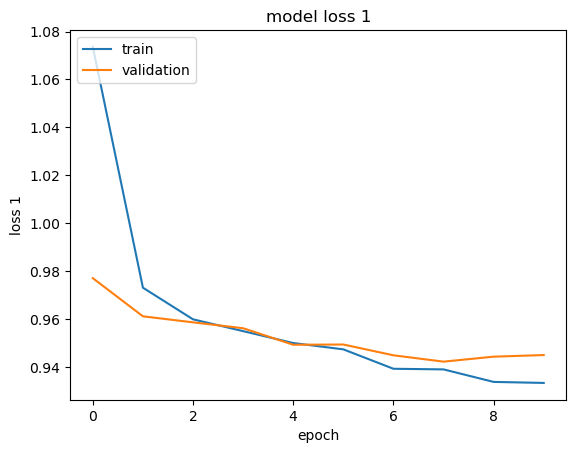

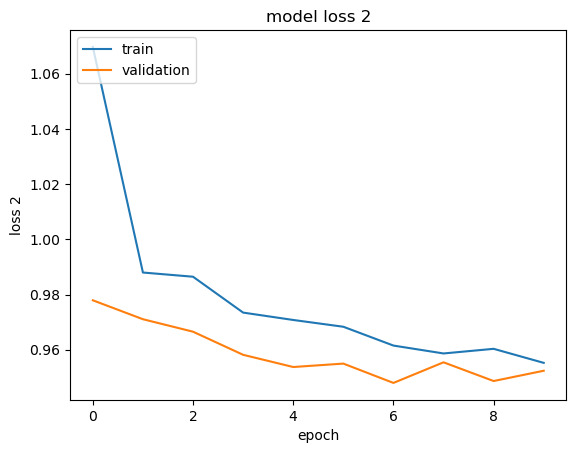

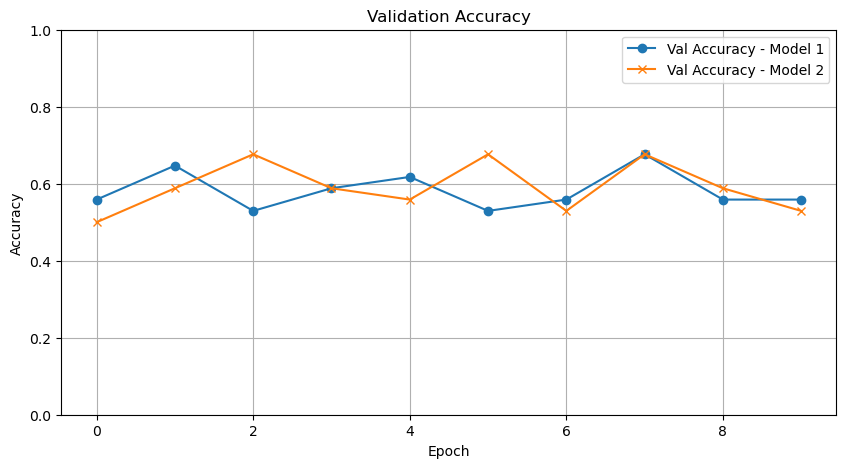

In [24]:
# Visualize training and validation loss on the same plot, and visualize the validation accuracy across epochs.
plt.plot(train_losses_1)
plt.plot(val_losses_1)
plt.title('model loss 1')
plt.ylabel('loss 1')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(train_losses_2)
plt.plot(val_losses_2)
plt.title('model loss 2')
plt.ylabel('loss 2')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(val_accuracies_1, label='Val Accuracy - Model 1', marker='o')
plt.plot(val_accuracies_2, label='Val Accuracy - Model 2', marker='x')

plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()
plt.grid(True)
plt.show()

### Evaluate

In [ ]:
# # Evaluate on the test dataset
# test_dataset = PockerDataset(X_test.values.astype(np.float32), y_test)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
# y_true_1, y_pred_1 = test(model1, test_loader)
# y_true_2, y_pred_2 = test(model2, test_loader)